In [15]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator  # pylint: disable=import-error, no-name-in-module
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer
from qiskit.visualization import array_to_latex
import numpy as np
from qiskit import assemble
from math import pi
from qiskit.visualization import plot_bloch_multivector, plot_histogram, array_to_latex
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import MCXGate
# import basic plot tools and circuits
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
import matplotlib.pyplot as plt
import numpy as np
import math
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

The circuit will have 6 qubits, 4 that represents the position and 2 that represents the coin. As we mentioned previously, the coin is a Grover coin, which is the diffuser in Grover's algorithm. We start by implementing this. 

In [16]:
one_step_circuit = QuantumCircuit(6, name=' ONE STEP') 
# Coin operator
one_step_circuit.h([4,5])
one_step_circuit.z([4,5])
one_step_circuit.cz(4,5)
one_step_circuit.h([4,5])
one_step_circuit.draw() 

q_0: ──────────────────
                       
q_1: ──────────────────
                       
q_2: ──────────────────
                       
q_3: ──────────────────
     ┌───┐┌───┐   ┌───┐
q_4: ┤ H ├┤ Z ├─■─┤ H ├
     ├───┤├───┤ │ ├───┤
q_5: ┤ H ├┤ Z ├─■─┤ H ├
     └───┘└───┘   └───┘

Now, let us implement the shift operator. We know that the walker can only move to neighboring nodes, and all neighboring nodes differ by only one bit. We want to move the walker according to the coin, and we move the walker by applying a NOT gate to one of the node qubits. If the coin is in state $\ket{11}$, we move the walker to the state in which the first node qubit differ. If the coin is $\ket{10}$ or $\ket{01}$, the walker moves to the state where the second and third qubit, respectively, differ. Finally, if the Grover coin is $\ket{00}$, we flip the fourth qubit. We implement this with CCNOT- and NOT gates after the Grover coin. Together, they are one step of a quantum walk on a 4-dimensional hypercube. 

In [17]:
# Shift operator function for 4d-hypercube
def shift_operator(circuit):
    for i in range(0,4):
        circuit.x(4)
        if i%2==0:
            circuit.x(5)
        circuit.ccx(4,5,i)

shift_operator(one_step_circuit)

one_step_gate = one_step_circuit.to_instruction() 
one_step_circuit.draw() 

┌───┐                              
q_0: ───────────────────────┤ X ├──────────────────────────────
                            └─┬─┘     ┌───┐                    
q_1: ─────────────────────────┼───────┤ X ├────────────────────
                              │       └─┬─┘     ┌───┐          
q_2: ─────────────────────────┼─────────┼───────┤ X ├──────────
                              │         │       └─┬─┘     ┌───┐
q_3: ─────────────────────────┼─────────┼─────────┼───────┤ X ├
     ┌───┐┌───┐   ┌───┐┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐└─┬─┘
q_4: ┤ H ├┤ Z ├─■─┤ H ├┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──
     ├───┤├───┤ │ ├───┤├───┤  │  └───┘  │  ├───┤  │  └───┘  │  
q_5: ┤ H ├┤ Z ├─■─┤ H ├┤ X ├──■─────────■──┤ X ├──■─────────■──
     └───┘└───┘   └───┘└───┘               └───┘

In [18]:
one_step_circuit.inverse().draw() 


┌───┐                       
q_0: ──────────────────────────────┤ X ├───────────────────────
                         ┌───┐     └─┬─┘                       
q_1: ────────────────────┤ X ├───────┼─────────────────────────
               ┌───┐     └─┬─┘       │                         
q_2: ──────────┤ X ├───────┼─────────┼─────────────────────────
     ┌───┐     └─┬─┘       │         │                         
q_3: ┤ X ├───────┼─────────┼─────────┼─────────────────────────
     └─┬─┘┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐┌───┐   ┌───┐┌───┐
q_4: ──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├┤ H ├─■─┤ Z ├┤ H ├
       │  └───┘  │  ├───┤  │  └───┘  │  ├───┤├───┤ │ ├───┤├───┤
q_5: ──■─────────■──┤ X ├──■─────────■──┤ X ├┤ H ├─■─┤ Z ├┤ H ├
                    └───┘               └───┘└───┘   └───┘└───┘

In [5]:
# Make controlled gates
inv_cont_one_step = one_step_circuit.inverse().control()
inv_cont_one_step_gate = inv_cont_one_step.to_instruction()
cont_one_step = one_step_circuit.control()
cont_one_step_gate = cont_one_step.to_instruction()

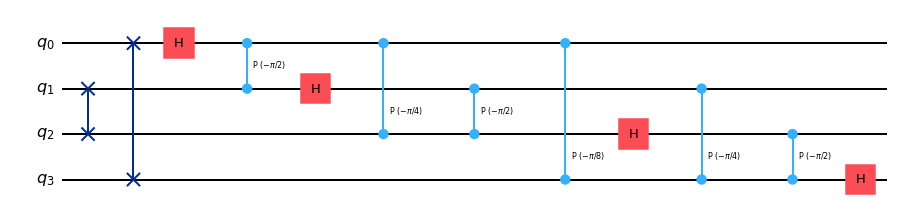

In [6]:
inv_qft_gate = QFT(4, inverse=True).to_instruction()  
qft_gate = QFT(4, inverse=False).to_instruction()

QFT(4, inverse=True).decompose().draw("mpl")

In [7]:
phase_circuit =  QuantumCircuit(6, name=' phase oracle ')
# Mark 1011
phase_circuit.x(2)
phase_circuit.h(3)
phase_circuit.mcx([0,1,2], 3)
phase_circuit.h(3)
phase_circuit.x(2)
# Mark 1111
phase_circuit.h(3)
phase_circuit.mcx([0,1,2],3)
phase_circuit.h(3)
phase_oracle_gate = phase_circuit.to_instruction()
# Phase oracle circuit
phase_oracle_circuit =  QuantumCircuit(11, name=' PHASE ORACLE CIRCUIT ')
phase_oracle_circuit.append(phase_oracle_gate, [4,5,6,7,8,9])
phase_circuit.draw() 

q_0: ───────■──────────────■───────
            │              │       
q_1: ───────■──────────────■───────
     ┌───┐  │  ┌───┐       │       
q_2: ┤ X ├──■──┤ X ├───────■───────
     ├───┤┌─┴─┐├───┤┌───┐┌─┴─┐┌───┐
q_3: ┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘
q_4: ──────────────────────────────
                                   
q_5: ──────────────────────────────

In [8]:
# Mark q_4 if the other qubits are non-zero 
mark_auxiliary_circuit = QuantumCircuit(5, name=' mark auxiliary ')
mark_auxiliary_circuit.x([0,1,2,3,4])
mark_auxiliary_circuit.mcx([0,1,2,3], 4)
mark_auxiliary_circuit.z(4)
mark_auxiliary_circuit.mcx([0,1,2,3], 4)
mark_auxiliary_circuit.x([0,1,2,3,4])

mark_auxiliary_gate = mark_auxiliary_circuit.to_instruction()
mark_auxiliary_circuit.draw()

┌───┐               ┌───┐
q_0: ┤ X ├──■─────────■──┤ X ├
     ├───┤  │         │  ├───┤
q_1: ┤ X ├──■─────────■──┤ X ├
     ├───┤  │         │  ├───┤
q_2: ┤ X ├──■─────────■──┤ X ├
     ├───┤  │         │  ├───┤
q_3: ┤ X ├──■─────────■──┤ X ├
     ├───┤┌─┴─┐┌───┐┌─┴─┐├───┤
q_4: ┤ X ├┤ X ├┤ Z ├┤ X ├┤ X ├
     └───┘└───┘└───┘└───┘└───┘

In [9]:
# Phase estimation
phase_estimation_circuit = QuantumCircuit(11, name=' phase estimation ')
phase_estimation_circuit.h([0,1,2,3])
for i in range(0,4):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(cont_one_step, [i,4,5,6,7,8,9])

# Inverse fourier transform
phase_estimation_circuit.append(inv_qft_gate, [0,1,2,3])

# Mark all angles theta that are not 0 with an auxiliary qubit
phase_estimation_circuit.append(mark_auxiliary_gate, [0,1,2,3,10])

# Reverse phase estimation
phase_estimation_circuit.append(qft_gate, [0,1,2,3])   

for i in range(3,-1,-1):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(inv_cont_one_step, [i,4,5,6,7,8,9])
phase_estimation_circuit.barrier(range(0,10))
phase_estimation_circuit.h([0,1,2,3])

# Make phase estimation gate
phase_estimation_gate = phase_estimation_circuit.to_instruction()
phase_estimation_circuit.draw() 

┌───┐┌──────────────┐                                                »
 q_0: ┤ H ├┤0             ├────────────────────────────────────────────────»
      ├───┤│              │┌──────────────┐┌──────────────┐                »
 q_1: ┤ H ├┤              ├┤0             ├┤0             ├────────────────»
      ├───┤│              ││              ││              │┌──────────────┐»
 q_2: ┤ H ├┤              ├┤              ├┤              ├┤0             ├»
      ├───┤│              ││              ││              ││              │»
 q_3: ┤ H ├┤              ├┤              ├┤              ├┤              ├»
      └───┘│              ││              ││              ││              │»
 q_4: ─────┤1             ├┤1             ├┤1             ├┤1             ├»
           │  c_ ONE STEP ││              ││              ││              │»
 q_5: ─────┤2             ├┤2 c_ ONE STEP ├┤2 c_ ONE STEP ├┤2             ├»
           │              ││              ││              ││  c_ ONE STEP │»
 q_6: ─────┤3             ├┤3             ├┤3             ├┤3             ├»
           │              ││              ││              ││              │»
 q_7: ─────┤4             ├┤4             ├┤4             ├┤4             ├»
           │              ││              ││              ││              │»
 q_8: ─────┤5             ├┤5             ├┤5             ├┤5             ├»
           │              ││              ││              ││              │»
 q_9: ─────┤6             ├┤6             ├┤6             ├┤6             ├»
           └──────────────┘└──────────────┘└──────────────┘└──────────────┘»
q_10: ─────────────────────────────────────────────────────────────────────»
                                                                           »
«                                                                      »
« q_0: ────────────────────────────────────────────────────────────────»
«                                                                      »
« q_1: ────────────────────────────────────────────────────────────────»
«      ┌──────────────┐┌──────────────┐┌──────────────┐                »
« q_2: ┤0             ├┤0             ├┤0             ├────────────────»
«      │              ││              ││              │┌──────────────┐»
« q_3: ┤              ├┤              ├┤              ├┤0             ├»
«      │              ││              ││              ││              │»
« q_4: ┤1             ├┤1             ├┤1             ├┤1             ├»
«      │              ││              ││              ││              │»
« q_5: ┤2             ├┤2             ├┤2             ├┤2             ├»
«      │  c_ ONE STEP ││  c_ ONE STEP ││  c_ ONE STEP ││              │»
« q_6: ┤3             ├┤3             ├┤3             ├┤3 c_ ONE STEP ├»
«      │              ││              ││              ││              │»
« q_7: ┤4             ├┤4             ├┤4             ├┤4             ├»
«      │              ││              ││              ││              │»
« q_8: ┤5             ├┤5             ├┤5             ├┤5             ├»
«      │              ││              ││              ││              │»
« q_9: ┤6             ├┤6             ├┤6             ├┤6             ├»
«      └──────────────┘└──────────────┘└──────────────┘└──────────────┘»
«q_10: ────────────────────────────────────────────────────────────────»
«                                                                      »
«                                                                      »
« q_0: ────────────────────────────────────────────────────────────────»
«                                                                      »
« q_1: ────────────────────────────────────────────────────────────────»
«                                                                      »
« q_2: ────────────────────────────────────────────────────────────────»
«      ┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
« q_3: ┤0             ├┤0             ├┤0    

In [10]:
# Implementation of the full quantum walk search algorithm
theta_q = QuantumRegister(4, 'theta')
node_q = QuantumRegister(4, 'node')
coin_q = QuantumRegister(2, 'coin')
auxiliary_q = QuantumRegister(1, 'auxiliary')
creg_c2 = ClassicalRegister(4, 'c')
circuit = QuantumCircuit(theta_q, node_q, coin_q, auxiliary_q, creg_c2)
# Apply Hadamard gates to the qubits that represent the nodes and the coin
circuit.h([4,5,6,7,8,9])
iterations = 2

for i in range(0,iterations):
    circuit.append(phase_oracle_gate, [4,5,6,7,8,9])
    circuit.append(phase_estimation_gate, [0,1,2,3,4,5,6,7,8,9,10])

circuit.measure(node_q[0], creg_c2[0])
circuit.measure(node_q[1], creg_c2[1])
circuit.measure(node_q[2], creg_c2[2])
circuit.measure(node_q[3], creg_c2[3])
circuit.draw()

┌──────────────────────┐                   »
  theta_0: ────────────────────────┤0                     ├───────────────────»
                                   │                      │                   »
  theta_1: ────────────────────────┤1                     ├───────────────────»
                                   │                      │                   »
  theta_2: ────────────────────────┤2                     ├───────────────────»
                                   │                      │                   »
  theta_3: ────────────────────────┤3                     ├───────────────────»
           ┌───┐┌─────────────────┐│                      │┌─────────────────┐»
   node_0: ┤ H ├┤0                ├┤4                     ├┤0                ├»
           ├───┤│                 ││                      ││                 │»
   node_1: ┤ H ├┤1                ├┤5   phase estimation  ├┤1                ├»
           ├───┤│                 ││                      ││                 │»
   node_2: ┤ H ├┤2                ├┤6                     ├┤2                ├»
           ├───┤│   phase oracle  ││                      ││   phase oracle  │»
   node_3: ┤ H ├┤3                ├┤7                     ├┤3                ├»
           ├───┤│                 ││                      ││                 │»
   coin_0: ┤ H ├┤4                ├┤8                     ├┤4                ├»
           ├───┤│                 ││                      ││                 │»
   coin_1: ┤ H ├┤5                ├┤9                     ├┤5                ├»
           └───┘└─────────────────┘│                      │└─────────────────┘»
auxiliary: ────────────────────────┤10                    ├───────────────────»
                                   └──────────────────────┘                   »
      c: 4/═══════════════════════════════════════════════════════════════════»
                                                                              »
«           ┌──────────────────────┐            
«  theta_0: ┤0                     ├────────────
«           │                      │            
«  theta_1: ┤1                     ├────────────
«           │                      │            
«  theta_2: ┤2                     ├────────────
«           │                      │            
«  theta_3: ┤3                     ├────────────
«           │                      │┌─┐         
«   node_0: ┤4                     ├┤M├─────────
«           │                      │└╥┘┌─┐      
«   node_1: ┤5   phase estimation  ├─╫─┤M├──────
«           │                      │ ║ └╥┘┌─┐   
«   node_2: ┤6                     ├─╫──╫─┤M├───
«           │                      │ ║  ║ └╥┘┌─┐
«   node_3: ┤7                     ├─╫──╫──╫─┤M├
«           │                      │ ║  ║  ║ └╥┘
«   coin_0: ┤8                     ├─╫──╫──╫──╫─
«           │                      │ ║  ║  ║  ║ 
«   coin_1: ┤9                     ├─╫──╫──╫──╫─
«           │                      │ ║  ║  ║  ║ 
«auxiliary: ┤10                    ├─╫──╫──╫──╫─
«           └──────────────────────┘ ║  ║  ║  ║ 
«      c: 4/═════════════════════════╩══╩══╩══╩═
«                                    0  1  2  3

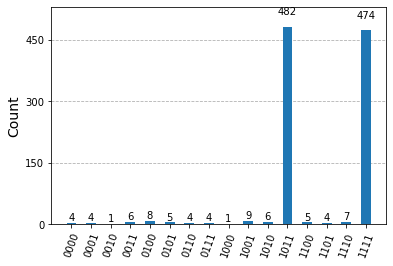

In [14]:
sim = Aer.get_backend('qasm_simulator')
result = sim.run(circuit.decompose(reps=6)).result()
counts = result.get_counts()
plot_histogram(counts)